In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [4]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g


def gradient_for_one_data(state, next_state, actor, critic):
    params = actor.trainable_weights  
    # q_func gradient tensor
    state_input = tf.constant([[state.tolist()]], tf.float32)
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.constant([[next_state.tolist()]], tf.float32)
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    gradient_for_one_state = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    return gradient_for_one_state

def gradient(states, ts, next_states, actor, critic):
    batch_size = len(states)
    for i in range(batch_size):
        state, t, next_state = states[i], ts[i], next_states[i]
        discount = np.exp(- alpha * t)
        g_tensor = gradient_for_one_data(state, next_state, actor, critic)
        g_tensor = [discount * g for g in g_tensor]
        if i == 0:
            out = [tf.constant(0.)] * len(g_tensor)
            out = [K.add(o, g) for o, g in zip(out, g_tensor)]
        else:
            out = [K.add(o, g) for o, g in zip(out, g_tensor)]
    func = K.function([], out)
    gg = func([[]])
    return gg

# Adam クラス
def learning_rate_arr(actor, size=674, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(674,) # 前回の勾配
        self.v = np.zeros(674,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [5]:
# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 20)
    S2 = np.linspace(-7, 7, 20)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    batch_size = 32
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    '''
    pg = 0
    # Q 関数の勾配を計算する
    for x, t in log:
        g = q_gradient([x], actor, critic)
        g = flatten_gradient(g)
        g *= np.exp(- alpha * t)
        pg += g
    '''
    tmp = []
    for i in range(len(log) - 1):
        tmp.append([log[i][0], log[i][1], log[i+1][0]])
    tmp = np.array(tmp)
    states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
    pg = gradient(states, ts, next_states, actor, critic)
    pg = flatten_gradient(pg)
    return pg

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 10.:
            log.append([x, episode_time])
            break
    return episode_reward


In [6]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')

In [15]:
actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
target_actor.load_weights('../saved_agent/mb_self_extend_noisy_actor.h5')
target_critic.load_weights('../saved_agent/mb_self_extend_noisy_critic.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)
ev = evaluation(actor)
print(f'value_function for initial policy = {ev}')
for i in range(1, 100):
    d_train = train_data(actor, noise=True)
    critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)#, epoch=int(5000//(1+np.sqrt(i-1))))
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -12.800075647708129
1-step
loss of critic is 0.01982700824737549, value_fuction V(s) = -9.540179708893575
|g| = 116.72556509328476
2-step
loss of critic is 0.047178320586681366, value_fuction V(s) = -7.694857778107138
|g| = 93.38113925313006
3-step
loss of critic is 0.10970263928174973, value_fuction V(s) = -5.996894086091785
|g| = 77.68604895605672
4-step
loss of critic is 0.4009111523628235, value_fuction V(s) = -4.912298648340157
|g| = 122.18445942237506
5-step
loss of critic is 0.7932718992233276, value_fuction V(s) = -4.774811068965879
|g| = 82.18015113914757
6-step
loss of critic is 0.7108376622200012, value_fuction V(s) = -10.568402351933942
|g| = 161.35123636666995
7-step
loss of critic is 1.0580986738204956, value_fuction V(s) = -13.305510384193063
|g| = 108.55951643109343
8-step
loss of critic is 1.1317278146743774, value_fuction V(s) = -13.456492275020924
|g| = 1629.1143318511624
9-step
loss of critic is 1.2208644151687622, value_fuction V

KeyboardInterrupt: 

In [13]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
# actor.load_weights('../saved_agent/mb_self_extend_noisy.h5')
initial_state = np.array([1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

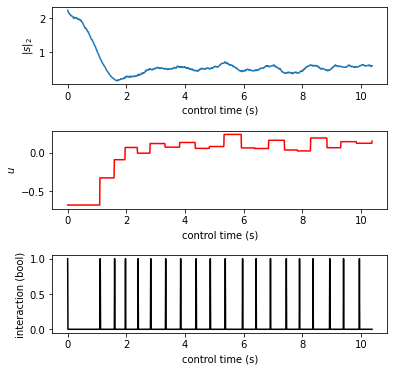

In [14]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

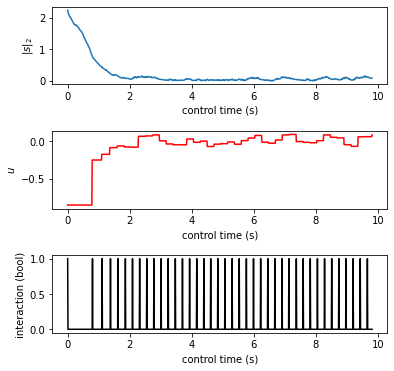

In [11]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [51]:
actor.save_weights('../saved_agent/learned_self_linear_ideal3_actor.h5')
critic.save_weights('../saved_agent/learned_self_linear_ideal3_critic.h5')

In [122]:
actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.41994604,  0.4266636 , -0.18461692,  0.16705216, -0.25361168,
        0.34438944,  0.10308936, -0.09404683, -0.1733037 , -0.22091635,
       -0.3533952 ,  0.02600434,  0.5435894 , -0.07042186, -0.3707666 ,
        0.3166266 ], dtype=float32)

In [121]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.layers[2].get_weights()[0][0]

array([ 0.42221597,  0.4274628 , -0.18825793,  0.16885139, -0.2542188 ,
        0.34214336,  0.10563881, -0.09488146, -0.17566861, -0.22360145,
       -0.3501546 ,  0.02824089,  0.54246134, -0.07161091, -0.37361035,
        0.31443065], dtype=float32)

In [12]:
%%time
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
lrs = learning_rate_arr(actor, size=674, u_lr=.0001, tau_lr=.001)
opt = Adam_original(lrs)

CPU times: user 4.39 s, sys: 151 ms, total: 4.54 s
Wall time: 4.97 s


In [18]:
%%time
# critic用のデータ採り
d_train = train_data(actor)

CPU times: user 3.69 s, sys: 58.2 ms, total: 3.75 s
Wall time: 4.09 s


In [30]:
%%time
critic, losses = td_learning(d_train, actor, critic, epoch=int(5000//np.sqrt(40)))

CPU times: user 2.19 s, sys: 232 ms, total: 2.43 s
Wall time: 1.81 s


In [33]:
%%time
pg = policy_gradient(actor, critic)

TypeError: gradient() missing 1 required positional argument: 'critic'

In [21]:
%%time
actor = opt.update(actor, pg/np.linalg.norm(pg))

CPU times: user 21.5 ms, sys: 3.52 ms, total: 25 ms
Wall time: 21.9 ms


In [72]:
%%time
init_state = np.array([1,2])
x = init_state
episode_time = 0
log = []
while True:
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    print(a_agent, tau)
    log.append([x, episode_time])
    reward, x = interaction(x, a_agent, tau, env, ln=0.1)
    episode_time += tau
    if episode_time >= 10.:
        log.append([x, episode_time])
        break

-0.47579882 2.0842226
-0.42807683 2.2787244
-1.5756315 4.1653085
-1.0088876 4.492806
CPU times: user 229 ms, sys: 9.46 ms, total: 238 ms
Wall time: 465 ms


In [73]:
%%time
pg = 0
# Q 関数の勾配を計算する
for i in range(1):
    s, t = log[i]
    s_prime = log[i+1][0]
    g = gradient_old(s, s_prime, actor, critic)
    g = flatten_gradient(g)
    g *= np.exp(- alpha * t)
    pg += g

CPU times: user 5.94 s, sys: 1.53 s, total: 7.47 s
Wall time: 9.16 s


In [74]:
pg

array([  46.84173584,   -2.91691399,    0.        ,    0.        ,
         -6.55131149,  -29.31933594,    2.29238129,    6.65651894,
        -25.69723892,  -41.6153183 ,    0.        ,   65.71923065,
         -4.50928116,   -6.16872597,    0.        ,  -56.7063942 ,
         93.68347168,   -5.83382797,    0.        ,    0.        ,
        -13.10262299,  -58.63867188,    4.58476257,   13.31303787,
        -51.39447784,  -83.2306366 ,    0.        ,  131.4384613 ,
         -9.01856232,  -12.33745193,    0.        , -113.41278839,
         46.84173584,   -2.91691399,    0.        ,    0.        ,
         -6.55131149,  -29.31933594,    2.29238129,    6.65651894,
        -25.69723892,  -41.6153183 ,    0.        ,   65.71923065,
         -4.50928116,   -6.16872597,    0.        ,  -56.7063942 ,
          0.        ,    0.        ,    0.        ,   20.41229057,
          0.        ,   10.91783524,    0.        ,    8.58461285,
          0.        ,   -7.05770636,    0.        ,    2.18348

In [75]:
%%time
tmp = []
for i in range(1):
    tmp.append([log[i][0], log[i][1], log[i+1][0]])
tmp = np.array(tmp)
states, ts, next_states = tmp[:,0], tmp[:,1], tmp[:,2]
pg = gradient(states, ts, next_states, actor, critic)
pg = flatten_gradient(pg)

CPU times: user 5.51 s, sys: 255 ms, total: 5.77 s
Wall time: 6.18 s


In [46]:
pg

array([-2.27420405e-01,  9.11211967e-03,  0.00000000e+00,  0.00000000e+00,
        3.26015204e-02,  1.32287651e-01, -1.60542130e-02, -2.64564678e-02,
        1.25089481e-01,  1.95075125e-01,  0.00000000e+00, -3.13965201e-01,
        1.64555907e-02,  2.53116041e-02,  0.00000000e+00,  2.62620240e-01,
       -4.54840809e-01,  1.82242393e-02,  0.00000000e+00,  0.00000000e+00,
        6.52030408e-02,  2.64575303e-01, -3.21084261e-02, -5.29129356e-02,
        2.50178963e-01,  3.90150249e-01,  0.00000000e+00, -6.27930403e-01,
        3.29111814e-02,  5.06232083e-02,  0.00000000e+00,  5.25240481e-01,
       -2.27420405e-01,  9.11211967e-03,  0.00000000e+00,  0.00000000e+00,
        3.26015204e-02,  1.32287651e-01, -1.60542130e-02, -2.64564678e-02,
        1.25089481e-01,  1.95075125e-01, -0.00000000e+00, -3.13965201e-01,
        1.64555907e-02,  2.53116041e-02,  0.00000000e+00,  2.62620240e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.77820250e-02,
        0.00000000e+00,  

In [27]:
%%time
g = gradient(s, s_prime, actor, critic)

CPU times: user 1.65 s, sys: 42.9 ms, total: 1.69 s
Wall time: 1.79 s


In [28]:
%%time
g = flatten_gradient(g)

CPU times: user 286 µs, sys: 17 µs, total: 303 µs
Wall time: 356 µs


In [16]:
sr = '''
1-step
loss of critic is 0.020467590540647507, value_fuction V(s) = -11.325844214057623
|g| = 94.47575058219529
2-step
loss of critic is 0.04651528224349022, value_fuction V(s) = -8.027125309112169
|g| = 124.918864290004
3-step
loss of critic is 0.0896289274096489, value_fuction V(s) = -6.576131001505591
|g| = 267.55596191867687
4-step
loss of critic is 0.21700800955295563, value_fuction V(s) = -5.366832441185897
|g| = 90.49167314938744
5-step
loss of critic is 0.5276165008544922, value_fuction V(s) = -17.030980503820217
|g| = 86.2179103997012
6-step
loss of critic is 0.7270787954330444, value_fuction V(s) = -17.849092233024137
|g| = 263.79127129671707
7-step
loss of critic is 1.4203863143920898, value_fuction V(s) = -16.145406962549398
|g| = 800.547973927166
8-step
loss of critic is 1.541619062423706, value_fuction V(s) = -8.40343146092323
|g| = 1457.5240999500581
9-step
loss of critic is 1.2702040672302246, value_fuction V(s) = -19.061536771291376
|g| = 1982.0029946294444
10-step
loss of critic is 1.1434745788574219, value_fuction V(s) = -33.98914252957364
|g| = 1255.8218387955317
11-step
loss of critic is 0.9129098653793335, value_fuction V(s) = -31.47153448507286
|g| = 1502.5652581338688
12-step
loss of critic is 1.0054681301116943, value_fuction V(s) = -27.443066789210473
|g| = 1401.1823589418536
13-step
loss of critic is 0.9195935726165771, value_fuction V(s) = -31.321236026807654
|g| = 860.4895914366094
14-step
loss of critic is 1.103319764137268, value_fuction V(s) = -37.97708389621189
|g| = 900.0712731068041
15-step
loss of critic is 1.2012666463851929, value_fuction V(s) = -29.285652813980704
|g| = 818.064143781415
16-step
loss of critic is 1.3954373598098755, value_fuction V(s) = -29.521298299045196
|g| = 1757.9655808714472
17-step
loss of critic is 1.3546631336212158, value_fuction V(s) = -27.718108007983833
|g| = 2356.3476774821074
18-step
loss of critic is 1.358264446258545, value_fuction V(s) = -32.965807720322694
|g| = 2398.7849593377728
19-step
loss of critic is 1.2160658836364746, value_fuction V(s) = -8.30341392447337
|g| = 436.9892798698788
20-step
loss of critic is 1.2366632223129272, value_fuction V(s) = -25.419238757725545
|g| = 1729.4450856892988
21-step
loss of critic is 1.0633676052093506, value_fuction V(s) = -26.399357911015226
|g| = 1544.8358169172955
22-step
loss of critic is 1.1302037239074707, value_fuction V(s) = -24.792271796852546
|g| = 1484.3151809897136
23-step
loss of critic is 1.0878952741622925, value_fuction V(s) = -16.966825695993705
|g| = 2456.317345039393
24-step
loss of critic is 1.145530104637146, value_fuction V(s) = -25.638888181718016
|g| = 5995.4240074395875
25-step
loss of critic is 1.3911142349243164, value_fuction V(s) = -25.80713785901301
|g| = 2523.203367506411
26-step
loss of critic is 1.3756473064422607, value_fuction V(s) = -23.5940823993945
|g| = 2518.786583336745
27-step
loss of critic is 1.6704941987991333, value_fuction V(s) = -25.964484423368976
|g| = 3291.094352751332
28-step
loss of critic is 1.3769240379333496, value_fuction V(s) = -14.028519800348374
|g| = 2630.6783295047853
29-step
loss of critic is 1.1454243659973145, value_fuction V(s) = -14.362945216298401
|g| = 5845.363222151752
30-step
loss of critic is 0.9878538846969604, value_fuction V(s) = -16.080778647827294
|g| = 5681.0463081800435
31-step
loss of critic is 0.9256574511528015, value_fuction V(s) = -14.273593228082266
|g| = 2857.0850015372107
32-step
loss of critic is 0.9340208768844604, value_fuction V(s) = -15.916244372944227
|g| = 942.383278180292
33-step
loss of critic is 0.9053748250007629, value_fuction V(s) = -12.309788843613909
|g| = 1102.9437470136334
34-step
loss of critic is 0.7933185696601868, value_fuction V(s) = -27.08327784210561
|g| = 2770.4201031807943
35-step
loss of critic is 0.6679218411445618, value_fuction V(s) = -28.009774333292555
|g| = 3973.2715628080377
36-step
loss of critic is 0.6741665005683899, value_fuction V(s) = -23.071729876047876
|g| = 4112.192707683853
37-step
loss of critic is 0.5973795652389526, value_fuction V(s) = -5.61891363919165
|g| = 4941.567369639442
38-step
loss of critic is 0.4539741277694702, value_fuction V(s) = -16.719347818032478
|g| = 1066.6830994477814
39-step
loss of critic is 0.8128309845924377, value_fuction V(s) = -5.571733996198955
|g| = 3224.5305015911877
40-step
loss of critic is 0.7955041527748108, value_fuction V(s) = -3.5913683578552162
|g| = 1176.9163493792319
41-step
loss of critic is 0.8179006576538086, value_fuction V(s) = -14.880149936214565
|g| = 1266.8128661267235
42-step
loss of critic is 0.8136103749275208, value_fuction V(s) = -3.0584678310657227
|g| = 896.55122263529
43-step
loss of critic is 0.6337532997131348, value_fuction V(s) = -3.424203443387357
|g| = 2818.84468520453
44-step
loss of critic is 0.7588875889778137, value_fuction V(s) = -3.6352825412315837
|g| = 487.1376495049642
45-step
loss of critic is 0.7759858965873718, value_fuction V(s) = -3.6722707561668817
|g| = 494.7300150933112
46-step
loss of critic is 0.6499950885772705, value_fuction V(s) = -4.07138461390337
|g| = 461.7582909999357
47-step
loss of critic is 0.6049790978431702, value_fuction V(s) = -3.878333191366509
|g| = 323.6951394809882
48-step
loss of critic is 0.5899669528007507, value_fuction V(s) = -3.3913836191173776
|g| = 190.33785643510637
49-step
loss of critic is 0.658024251461029, value_fuction V(s) = -3.998982586939452
|g| = 674.7865965178318
50-step
loss of critic is 0.4371515214443207, value_fuction V(s) = -3.0932824311782783
|g| = 304.9283293405532
51-step
loss of critic is 0.5500014424324036, value_fuction V(s) = -3.309534241752856
|g| = 353.2869920547377
52-step
loss of critic is 0.5400466918945312, value_fuction V(s) = -3.545918690315828
|g| = 249.10367872836252
53-step
loss of critic is 0.6017665266990662, value_fuction V(s) = -6.358496635271249
|g| = 196.74219381462922
54-step
loss of critic is 0.6769999861717224, value_fuction V(s) = -7.7718033013427155
|g| = 139.61364904573514
55-step
loss of critic is 0.6361933350563049, value_fuction V(s) = -7.63323753203347
|g| = 851.2756840521951
56-step
loss of critic is 0.6977019309997559, value_fuction V(s) = -6.741214020345181
|g| = 1395.5385205876173
57-step
loss of critic is 0.7246301770210266, value_fuction V(s) = -4.524824917466754
|g| = 245.78801979671152
58-step
loss of critic is 0.7158443331718445, value_fuction V(s) = -5.170174927554329
|g| = 323.5664821581734
59-step
loss of critic is 0.6275560259819031, value_fuction V(s) = -6.527127465558836
|g| = 262.6602232647745
60-step
loss of critic is 0.6922690868377686, value_fuction V(s) = -5.955256955832239
|g| = 2795.3157797154076
61-step
loss of critic is 0.6197370290756226, value_fuction V(s) = -4.408740844134782
|g| = 862.0531330834058
62-step
loss of critic is 0.8609728813171387, value_fuction V(s) = -4.5050663040517565
|g| = 329.66356666438037
63-step
loss of critic is 0.6392350792884827, value_fuction V(s) = -6.248491324610096
|g| = 675.5087647440841
64-step
loss of critic is 0.8731857538223267, value_fuction V(s) = -3.7732003595001795
|g| = 627.0415049907508
65-step
loss of critic is 0.567602813243866, value_fuction V(s) = -4.576626002118534
|g| = 209.31185774773584
66-step
loss of critic is 0.6622723340988159, value_fuction V(s) = -4.706975808057825
|g| = 329.1678798459232
67-step
loss of critic is 0.6348785161972046, value_fuction V(s) = -4.146863080182118
|g| = 235.1770099157468
68-step
loss of critic is 0.5498971939086914, value_fuction V(s) = -3.384605327756582
|g| = 280.0339078261292
69-step
loss of critic is 0.5568116903305054, value_fuction V(s) = -10.33181571771131
|g| = 485.2463895486027
70-step
loss of critic is 0.6858614087104797, value_fuction V(s) = -4.881950844899055
|g| = 328.2375416353883
71-step
loss of critic is 0.4455448389053345, value_fuction V(s) = -3.450010058920329
|g| = 8557.374865807884
72-step
loss of critic is 0.6310652494430542, value_fuction V(s) = -13.068641117616739
|g| = 438.72158686135043
73-step
loss of critic is 0.6040701866149902, value_fuction V(s) = -15.301060004845176
|g| = 1126.847767060578
74-step
loss of critic is 0.6972496509552002, value_fuction V(s) = -14.846191391764187
|g| = 1311.5313790330779
75-step
loss of critic is 0.983533501625061, value_fuction V(s) = -10.175627892306528
|g| = 325.4812304477783
76-step
loss of critic is 0.8717923760414124, value_fuction V(s) = -4.770874328793717
|g| = 1452.6556437264105
77-step
loss of critic is 0.9443126916885376, value_fuction V(s) = -6.462529171240053
|g| = 492.31831955793865
78-step
loss of critic is 1.0836634635925293, value_fuction V(s) = -13.158283933678753
|g| = 649.96498548384
79-step
loss of critic is 0.7377101182937622, value_fuction V(s) = -5.231741214717815
|g| = 2711.1709085815237
80-step
loss of critic is 1.3681899309158325, value_fuction V(s) = -5.3931613317683595
|g| = 3712.21220782768
81-step
loss of critic is 1.3654831647872925, value_fuction V(s) = -4.889720007787852
|g| = 985.5203602779948
82-step
loss of critic is 1.1794730424880981, value_fuction V(s) = -6.8277861858080975
|g| = 1189.9687268143794
83-step
loss of critic is 1.6596750020980835, value_fuction V(s) = -4.412549491701412
|g| = 6156.4566266095035
84-step
loss of critic is 1.4524177312850952, value_fuction V(s) = -6.475041354510959
|g| = 2799.6783225993636
85-step
loss of critic is 1.8490694761276245, value_fuction V(s) = -10.884097644355514
|g| = 1213.646018831703
86-step
loss of critic is 1.423719882965088, value_fuction V(s) = -10.60102085403026
|g| = 2191.9275843438186
87-step
loss of critic is 1.426257848739624, value_fuction V(s) = -11.62048517581898
|g| = 2078.7733787617394
88-step
loss of critic is 1.8893672227859497, value_fuction V(s) = -10.526673071044174
|g| = 1928.1396866556063
89-step
loss of critic is 1.5620861053466797, value_fuction V(s) = -9.232859108973534
|g| = 1970.9957718983935
90-step
loss of critic is 1.4389197826385498, value_fuction V(s) = -5.272979627555292
|g| = 779.5194308163284
91-step
loss of critic is 1.6749249696731567, value_fuction V(s) = -3.970310741048826
|g| = 339.42536766965696
92-step
loss of critic is 1.4391368627548218, value_fuction V(s) = -7.43813600866056
|g| = 739.9023245117661
93-step
loss of critic is 1.164074420928955, value_fuction V(s) = -4.990196802352988
|g| = 930.1447546704188
94-step
loss of critic is 1.289821743965149, value_fuction V(s) = -3.9774002113203513
|g| = 587.4555718152919
95-step
loss of critic is 1.184903860092163, value_fuction V(s) = -12.242528655124161
|g| = 570.6495212028722
96-step
loss of critic is 1.0197253227233887, value_fuction V(s) = -3.741878279476585
|g| = 680.6476504682882
97-step
loss of critic is 1.358142614364624, value_fuction V(s) = -4.425855265873541
|g| = 478.2338516598185
98-step
loss of critic is 0.6761030554771423, value_fuction V(s) = -6.4647952307818795
|g| = 519.225812732277
99-step
loss of critic is 0.9638193249702454, value_fuction V(s) = -7.4593372473528134
|g| = 2231.3470780449475

'''

In [17]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

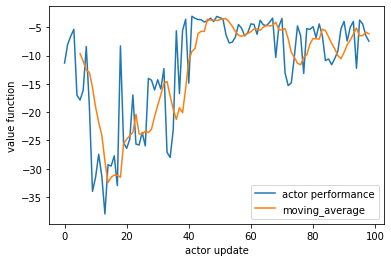

In [18]:
#rs = rs[15:]
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()